<h1><font color="#113D68" size=6>Deep Learning con Python y Keras</font></h1>

<h1><font color="#113D68" size=5>Parte 6. Redes Neuronales Recurrentes</font></h1>

<h1><font color="#113D68" size=4>2. Series de Tiempo con MLP</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo Cara</font><br>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [0. Contexto](#section0)
* [1. Predicción en series temporales](#section1)
* [2. MLP para regresión](#section2)
    * [2.1. Cargar el dataset](#section2.1)
    * [2.2. Entretamiento](#section2.2)
    * [2.3. Predicción en Y](#section2.3)
    * [2.4. Desarrollo MLP](#section2.4)
    * [2.5. Estimar el rendimiento del modelo](#section2.5)
    * [2.6. Predicciones del modelo](#section2.6)
* [3. MLP mediante el método de ventana](#section3)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. Contexto</font>

En esta lección, aprenderesmo a desarrollar modelos de redes neuronales para la predicción de series de tiempo:
* Predicción de series de tiempo en un ejemplo práctico.
* Desarrollar un modelo de red neuronal para Series temporales.
* Desarrollar un modelo de red neuronal para Series de tiempo con desfase.

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section1"></a>
# <font color="#004D7F" size=6>1. Predicción en series temporales</font>

El problema que veremos es un problema de predicción de pasajeros de aerolíneas internacionales. Este es un problema en el que, dado un año y un mes, la tarea es predecir el número de pasajeros de aerolíneas internacionales en unidades de 1.000. Los datos van desde enero de 1949 hasta diciembre de 1960 o 12 años, con 144 observaciones. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información sobre el dataset [Air Passengers](https://www.kaggle.com/chirag19/air-passengers)

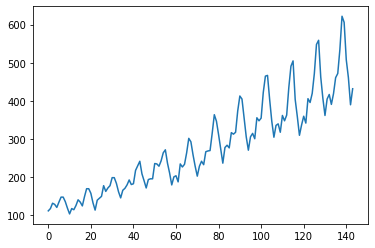

In [1]:
# Declare libraries and dataset
import pandas as pd
import matplotlib.pyplot as plt
dataset = pd.read_csv("https://raw.githubusercontent.com/FMunyoz/colab/main/data/international-airline-passengers.csv", usecols=[1], engine='python')

#print(dataset.head(5))
plt.plot(dataset)
plt.show()

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6>2. MLP para regresión</font>

Podemos escribir una función simple para convertir nuestra única columna de datos en un conjunto de datos de dos columnas. La primera columna contiene el recuento de pasajeros $(t)$ de este mes y la segunda columna contiene el recuento de pasajeros $(t + 1)$ del próximo mes (por predecir). 

<a id="section2.1"></a>
# <font color="#004D7F" size=5>2.1. Cargar el dataset</font>

Antes de comenzar, primero importemos todas las funciones y clases que pretendemos usar.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense

# load the dataset
dataframe = pd.read_csv("https://raw.githubusercontent.com/FMunyoz/colab/main/data/international-airline-passengers.csv", usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

<a id="section2.2"></a>
# <font color="#004D7F" size=5>2.2. Entretamiento</font>

Con datos de series de tiempo, la secuencia de valores es importante. Un método simple para entrenamiento es dividir el conjunto de datos ordenado en conjuntos de datos de prueba/validación. En este caso vamos a modelarlo en 67% para prueba y 33% para validación.

In [3]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
train_test = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
test


array([[315.],
       [301.],
       [356.],
       [348.],
       [355.],
       [422.],
       [465.],
       [467.],
       [404.],
       [347.],
       [305.],
       [336.],
       [340.],
       [318.],
       [362.],
       [348.],
       [363.],
       [435.],
       [491.],
       [505.],
       [404.],
       [359.],
       [310.],
       [337.],
       [360.],
       [342.],
       [406.],
       [396.],
       [420.],
       [472.],
       [548.],
       [559.],
       [463.],
       [407.],
       [362.],
       [405.],
       [417.],
       [391.],
       [419.],
       [461.],
       [472.],
       [535.],
       [622.],
       [606.],
       [508.],
       [461.],
       [390.],
       [432.]], dtype=float32)

<a id="section2.3"></a>
# <font color="#004D7F" size=5>2.3. Predicción en $Y$</font>

Ahora podemos definir una función para crear un nuevo conjunto de datos como se describe arriba. 
La función toma dos argumentos:
* El **conjunto de datos,** que es una matriz NumPy y
* La **"vista hacia atrás"**: que es el número de pasos de tiempo anteriores, predeterminado a 1. 
    * Este valor predeterminado creará un conjunto de datos donde $X$ es el número de pasajeros en un momento dado $(t)$ e $Y$ es el número de pasajeros en el siguiente momento $(t + 1)$. 

In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [],[]
    for i in range(len(dataset) - look_back-1):
        a = dataset[i: (i+look_back),0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Si nos fijamos podemos observar el patrón $X = t$ y $Y = t + 1$ en los números. 
```
   X1  Y  
   112 118
   118 132
   132 129
   129 121
   121 135 
```

In [5]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

for i in range(5):
  print(trainX[i], trainY[i])

[112.] 118.0
[118.] 132.0
[132.] 129.0
[129.] 121.0
[121.] 135.0


<a id="section2.4"></a>
# <font color="#004D7F" size=5>2.4. Desarrollo MLP</font>

Usamos una red simple:
1. con 1 entrada.
2. 1 capa oculta con 8 neuronas y 
3. 1 capa de salida.
4. El modelo se ajusta usando el error cuadrático medio

In [6]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)


Epoch 1/200
47/47 - 14s - loss: 267320.3125
Epoch 2/200
47/47 - 0s - loss: 218077.3594
Epoch 3/200
47/47 - 0s - loss: 178926.6562
Epoch 4/200
47/47 - 0s - loss: 146715.9375
Epoch 5/200
47/47 - 0s - loss: 119386.6562
Epoch 6/200
47/47 - 0s - loss: 95571.3047
Epoch 7/200
47/47 - 0s - loss: 75222.2734
Epoch 8/200
47/47 - 0s - loss: 57891.5039
Epoch 9/200
47/47 - 0s - loss: 43329.3945
Epoch 10/200
47/47 - 0s - loss: 31479.2266
Epoch 11/200
47/47 - 0s - loss: 22099.1270
Epoch 12/200
47/47 - 0s - loss: 15019.5850
Epoch 13/200
47/47 - 0s - loss: 9826.6152
Epoch 14/200
47/47 - 0s - loss: 6266.4722
Epoch 15/200
47/47 - 0s - loss: 3890.2490
Epoch 16/200
47/47 - 0s - loss: 2411.3030
Epoch 17/200
47/47 - 0s - loss: 1530.3336
Epoch 18/200
47/47 - 0s - loss: 1042.4152
Epoch 19/200
47/47 - 0s - loss: 783.0812
Epoch 20/200
47/47 - 0s - loss: 647.4547
Epoch 21/200
47/47 - 0s - loss: 585.8946
Epoch 22/200
47/47 - 0s - loss: 558.6618
Epoch 23/200
47/47 - 0s - loss: 542.8047
Epoch 24/200
47/47 - 0s - loss

<a id="section2.5"></a>
# <font color="#004D7F" size=5>2.5. Estimar el rendimiento del modelo</font>

Una vez que el modelo se ajusta, podemos estimar el rendimiento del modelo en el train/test.

In [9]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Puntuación Entrenamiento: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testX, verbose=0)
print('Puntuación Validación: %.2f MSE (%.2f RMSE)'% (testScore, math.sqrt(testScore)))

Puntuación Entrenamiento: 529.27 MSE (23.01 RMSE)
Puntuación Validación: 4.42 MSE (2.10 RMSE)


<a id="section2.6"></a>
# <font color="#004D7F" size=5>2.6. Predicciones del modelo</font>

Finalmente, podemos generar predicciones. Los datos se grafican, mostrando el conjunto de datos original en azul, las predicciones de train en verde y las predicciones de test en rojo.

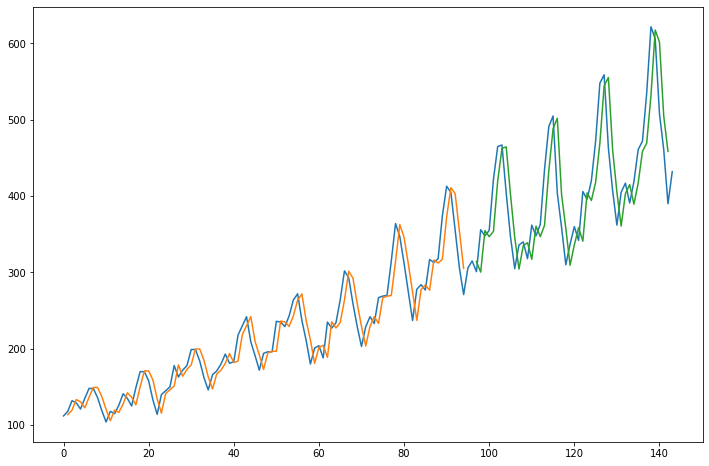

In [12]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(trainPredict)+look_back, :] =trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) +(look_back*2) + 1 : len(dataset)-1, :] =testPredict

# plot baseline and predictions
plt.figure(figsize=(12, 8))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6>3. MLP mediante el método de ventana</font>

Hacer la predicción para el próximo paso de tiempo se denomina método de ventana y el tamaño de la ventana es un parámetro que se puede ajustar. 

Por ejemplo, dado el tiempo actual $(t)$ que queremos predecir el valor en el próximo tiempo en la secuencia $(t + 1)$, podemos usar el tiempo actual $(t)$ así como los dos tiempos anteriores ($t-1$ y $t-2$). Por tanto: 
* Las variables de entrada son $t-2$, $t-1$, $t$ y 
* La variable de salida es $t + 1$.
Nuestro problema quedaría como:
```
   X1  X2  X3  Y
   112 118 132 129
   118 132 129 121
   132 129 121 135
   129 121 135 148
   121 135 148 148 
```

La función `create_dataset()` permite crear el tamaño de ventana con el argumento `look_back` de 1 a 3.

Agrandamos nuestra arquitectura:
* La primera capa oculta se aumenta a 14 neuronas
* Agregamos una segunda capa oculta con 8 neuronas. 
* El número de épocas se incrementa a 400.

Epoch 1/400
46/46 - 0s - loss: 990.0232
Epoch 2/400
46/46 - 0s - loss: 579.7127
Epoch 3/400
46/46 - 0s - loss: 588.0167
Epoch 4/400
46/46 - 0s - loss: 570.2631
Epoch 5/400
46/46 - 0s - loss: 587.7612
Epoch 6/400
46/46 - 0s - loss: 566.5220
Epoch 7/400
46/46 - 0s - loss: 672.2064
Epoch 8/400
46/46 - 0s - loss: 576.5897
Epoch 9/400
46/46 - 0s - loss: 580.5333
Epoch 10/400
46/46 - 0s - loss: 575.7706
Epoch 11/400
46/46 - 0s - loss: 628.0972
Epoch 12/400
46/46 - 0s - loss: 583.8867
Epoch 13/400
46/46 - 0s - loss: 586.9686
Epoch 14/400
46/46 - 0s - loss: 614.6171
Epoch 15/400
46/46 - 0s - loss: 513.9657
Epoch 16/400
46/46 - 0s - loss: 545.0740
Epoch 17/400
46/46 - 0s - loss: 569.2574
Epoch 18/400
46/46 - 0s - loss: 531.5513
Epoch 19/400
46/46 - 0s - loss: 537.4964
Epoch 20/400
46/46 - 0s - loss: 511.3044
Epoch 21/400
46/46 - 0s - loss: 660.6293
Epoch 22/400
46/46 - 0s - loss: 532.9128
Epoch 23/400
46/46 - 0s - loss: 501.7430
Epoch 24/400
46/46 - 0s - loss: 554.5485
Epoch 25/400
46/46 - 0s -

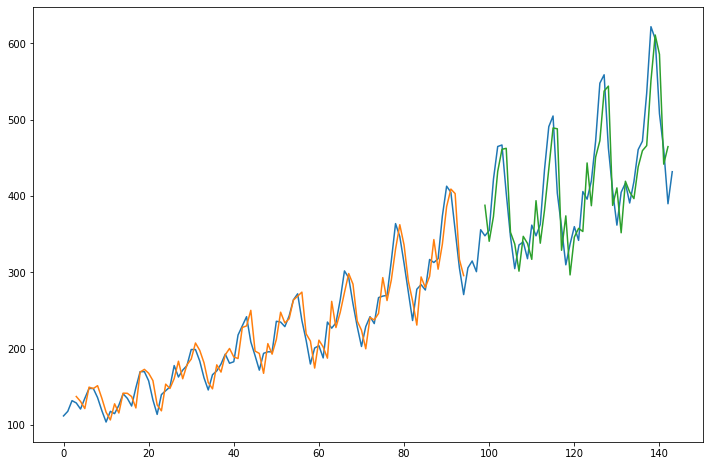

In [14]:

# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(12, input_dim=look_back, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size = 2, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Puntuación Entrenamiento: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testX, verbose=0)
print('Puntuación Validación: %.2f MSE (%.2f RMSE)'% (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back: len(trainPredict)+look_back, :] =trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) +(look_back*2) + 1 : len(dataset)-1, :] =testPredict

# plot baseline and predictions
plt.figure(figsize=(12, 8))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>